# Analysis of scRNA-seq data from activated PBMCs in TWINS only

In CVID and healthy control, 10X platform

09.02.2021: reanalysis, correcting the bug in bertie function

(Preprocessing happened in notebook M0)

Step-by-step workflow - **different to the scRNA-seq integration in doublet calling**:
- load preprocessed object
- do SCTransfor instead of normalising & log transforming
- save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- filter out cell cycle genes
- subset to HVGs
- (skipping scaling, not necessary because we've done SCTransform)
- pca (can also do preliminary neighbors/bbknn+umap here to peak at the data)
- **train a logreg model and add annotation (before it used to be earlier in the workflow)**
- neighbors/bbknn - deciding on which batch correction we will be using
- perform **step 2** of bertie doublet calling (requires running louvain clustering, see code)
- umap
- unbiased clustering
- save

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.7.3
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1611176215154/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1610315727443/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1610991770283/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1611678357911/work
blinker==1.

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.4
chardet             3.0.4
cloudpickle         1.6.0
colorama            0.4.4
constants           NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.2
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.2
jinja2              2.11.2
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.2
jupyterla

A Benjamini-Hochberg function for later. Running FDR is surprisingly inconvenient using built-in Python options.

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

## Reding the preprocessed object

Preprocessing happened in M1-0 notebook, preliminary analysis - in notebook M1-1

In [6]:
# reading
adata = sc.read(save_path+'adata_raw_filtered.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 17662 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

In [68]:
# reading object with final annotation (as done in M4 notebook)
adata_final_annot = sc.read(save_path + 'adata_hvg_bbknn_by_sample_nodoublets_20_PCs.h5ad')

In [69]:
adata_final_annot

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain', 'louvain_R_1_3', 'cell_type', 'barcode', 'louvain_R_7', 'louvain_R_7,0', 'louvain_R_4', 'louvain_R_5', 'louvain_R_8', 'louvain_R_2', 'louvain_R_2,1', 'louvain_R_0', 'louvain_R_6', 'GC_celltype_predictions', 'GC_celltype_prediction_probabilities', 'N_USM_SM_predictions', 'N_USM_SM_prediction_probabilities', 'naive_memory_predictions_Hamish', 'naive_memory_predictions_Hamish_probabilities'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genom

In [10]:
#len(set(adata.obs_names) & set(adata_final_annot.obs_names))

In [70]:
np.unique(adata_final_annot.obs['cell_type'], return_counts=True)

(array(['B:T_doublets_by_BCR', 'B_cells_memory',
        'B_cells_memory_activated', 'B_cells_naive',
        'B_cells_naive_activated', 'B_cells_oligoclonal', 'MAIT_cells',
        'MAIT_cells_activated', 'Myeloid_cells', 'NK_CD16_bright',
        'NK_CD16_bright_activated', 'NK_CD56_bright',
        'NK_CD56_bright_activated', 'T4_activated', 'T4_memory',
        'T4_naive', 'T8_activated_1', 'T8_activated_2', 'T8_memory',
        'T8_naive', 'T_gd', 'T_regs'], dtype=object),
 array([ 210,  391, 2472, 1568,  696,  196,  299,  219,  285,  763, 1235,
         238,  200, 1739, 1772,  675,  830,  288,  558,  408,  697, 1576]))

In [71]:
# discarding B:T_doublets_by_BCR cluster
adata_final_annot = adata_final_annot[-adata_final_annot.obs['cell_type'].isin(['B:T_doublets_by_BCR'])].copy()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [72]:
adata_final_annot

AnnData object with n_obs × n_vars = 17105 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain', 'louvain_R_1_3', 'cell_type', 'barcode', 'louvain_R_7', 'louvain_R_7,0', 'louvain_R_4', 'louvain_R_5', 'louvain_R_8', 'louvain_R_2', 'louvain_R_2,1', 'louvain_R_0', 'louvain_R_6', 'GC_celltype_predictions', 'GC_celltype_prediction_probabilities', 'N_USM_SM_predictions', 'N_USM_SM_prediction_probabilities', 'naive_memory_predictions_Hamish', 'naive_memory_predictions_Hamish_probabilities'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genom

In [14]:
# subsetting adata to only final cells
adata = adata[adata_final_annot.obs_names,:].copy()

In [15]:
adata

AnnData object with n_obs × n_vars = 17105 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

In [16]:
# transferring annotation along with some other useful metrics

cols2add = ['probabilities', 'celltype_predictions', 'cell_type']

for col in cols2add:
    adata.obs[col] = adata_final_annot.obs.loc[adata.obs_names, col]

In [17]:
np.unique(adata.obs['sample'])

array(['Immunodeficiency8103070', 'Immunodeficiency8103072',
       'Immunodeficiency8103073', 'Immunodeficiency8103074',
       'Immunodeficiency8103076', 'Immunodeficiency8103077'], dtype=object)

In [18]:
expr_mtx_check = adata[adata.obs['sample'] == 'Immunodeficiency8103070'].X.todense()
np.unique(expr_mtx_check)

matrix([[   0.,    0.,    0., ..., 2261., 2508., 2668.]], dtype=float32)

___________

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [19]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Second step of bertie doublet removal - will be done later in the pipeline

_____________________________________________________________________________________________________________________________________________________________

### Filter Cell cycle genes 
Per genes analysis: identify genes behaving like known cell cycle genes

There are no cycle genes, so skipping this here

extracting highly variable genes
    finished (0:00:00)


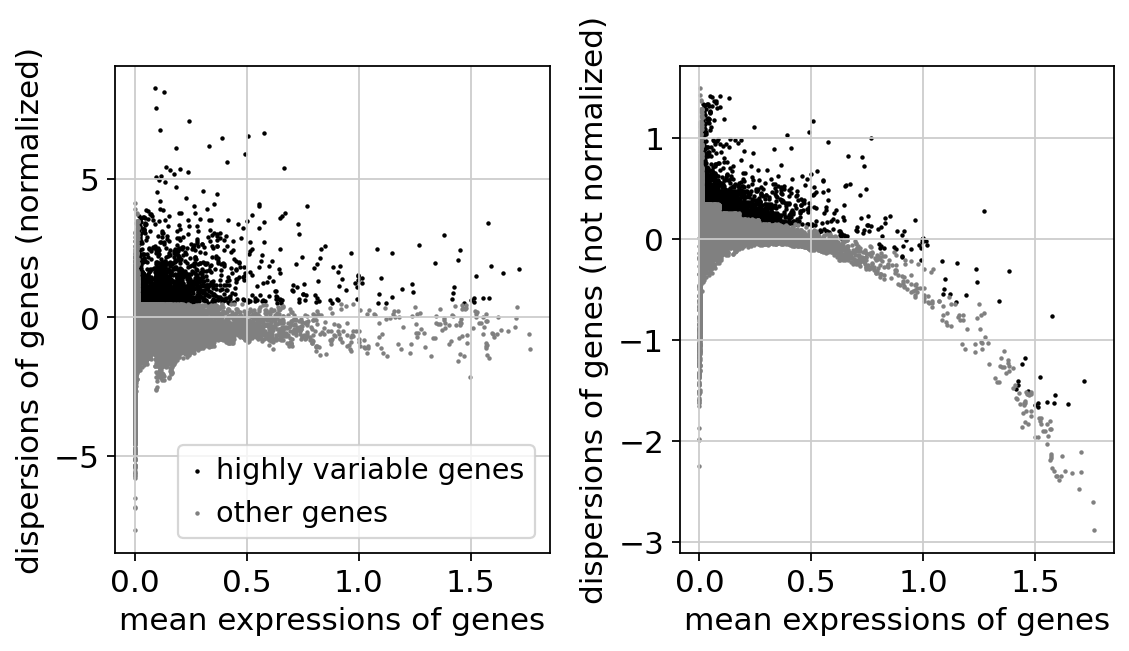

In [20]:
cellcycle_adata = adata.copy()
# Extract highly variable genes
filter_result = sc.pp.filter_genes_dispersion(
    cellcycle_adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result,save='_ccg_identification.pdf')

In [21]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]


/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [22]:
%%time
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# Scatter plot in PCA coordinates
sc.tl.pca(cellcycle_adata, n_comps=30)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=30
    finished (0:00:01)
CPU times: user 9.51 s, sys: 8.18 s, total: 17.7 s
Wall time: 2.05 s


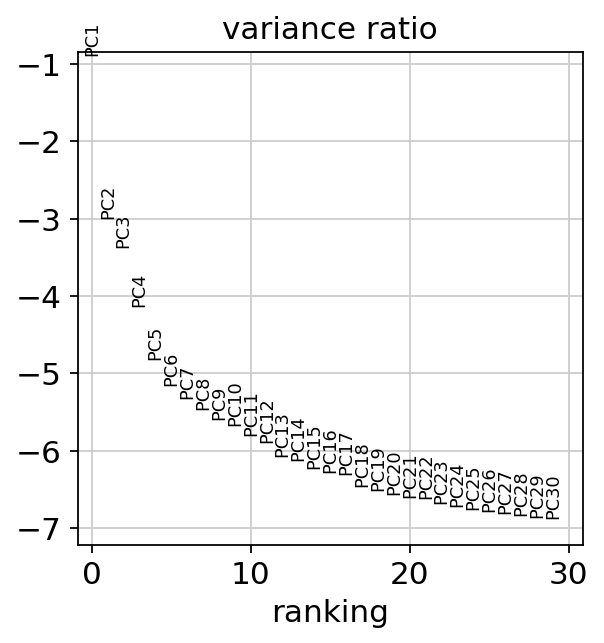

In [23]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True, save='_ccg_identification.pdf')

computing neighbors
    using 'X_pca' with n_pcs = 18
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


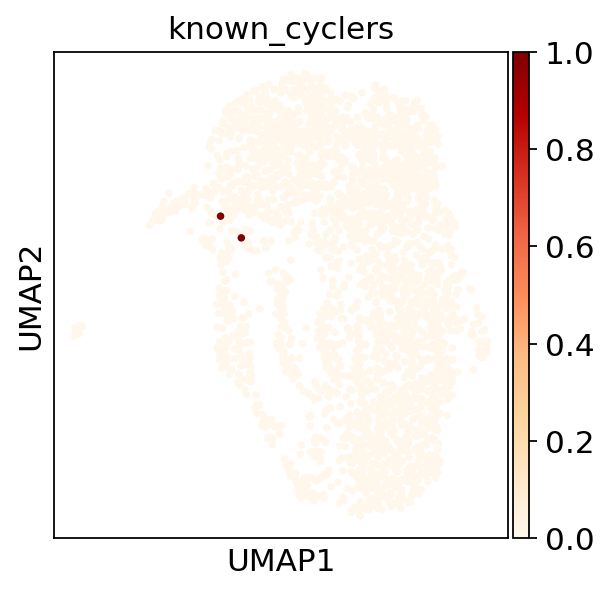

In [24]:
# Identify genes behaving like cc genes
num_pcs = 18
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd',save='_ccg_identification.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


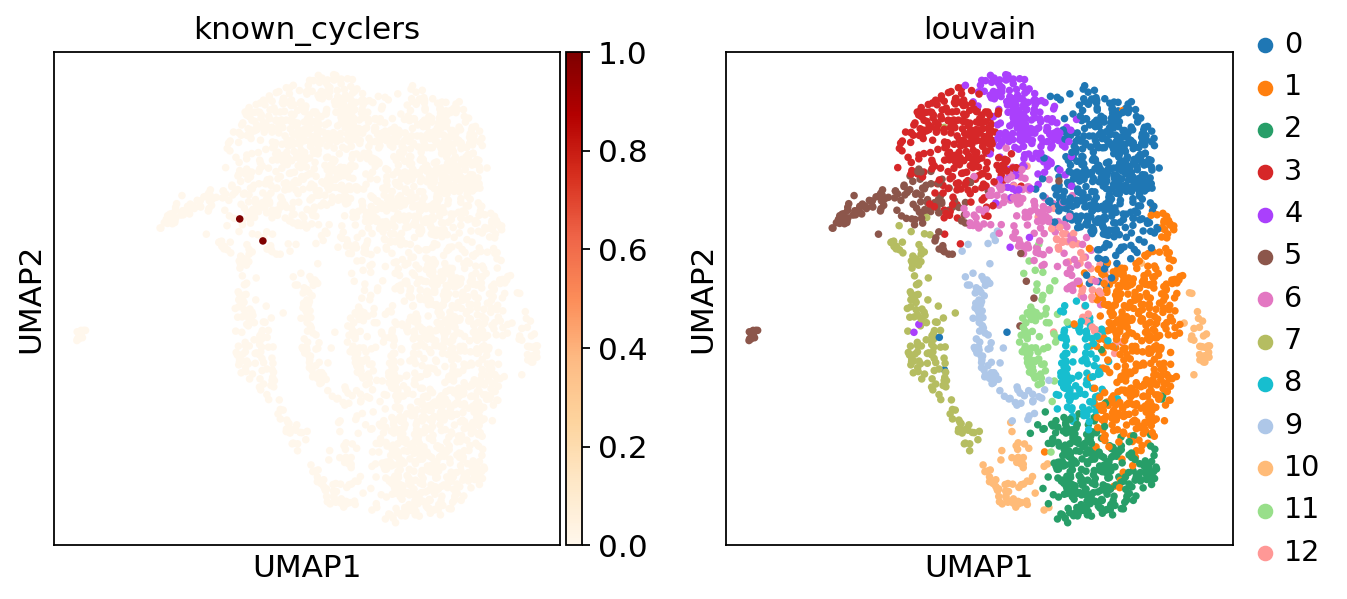

In [25]:
# Cluster GENES into subgroups using louvain
sc.tl.louvain(cellcycle_adata, resolution=1.0)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers',
                                  'louvain'],color_map='OrRd',save='_ccg_identification.pdf')

In [26]:
'CDK1' in cellcycle_adata.obs_names

False

In [27]:
'MKI67' in cellcycle_adata.obs_names

True

In [28]:
'CCNB2' in cellcycle_adata.obs_names

False

In [29]:
'PCNA' in cellcycle_adata.obs_names

True

In [30]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[[#'CDK1',
    'MKI67',
    #'CCNB2',
    'PCNA'],'louvain'])


index
MKI67    5
PCNA     5
Name: louvain, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']


In [31]:
adata

AnnData object with n_obs × n_vars = 17105 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'log1p'

So removing genes from cluster 5 by filtering the main matrix

In [32]:
# Add unstructured dict-like annotation for ccgs
adata.uns['ccgs'] = list(cellcycle_adata.obs[(cellcycle_adata.obs['louvain']=='5')].index)
# Remove cc genes
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]


/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [33]:
adata

View of AnnData object with n_obs × n_vars = 17105 × 17832
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'log1p', 'ccgs'

In [34]:
%%time
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# takes a few minutes

calculating cell cycle phase
computing score 'S_score'


Trying to set attribute `.obs` of view, copying.


    finished: added
    'S_score', score of gene set (adata.obs).
    464 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    702 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
CPU times: user 1.3 s, sys: 252 ms, total: 1.55 s
Wall time: 1.55 s


In [35]:
adata

AnnData object with n_obs × n_vars = 17105 × 17832
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'log1p', 'ccgs'

_______________________________________________________________________________________________________

# Subsetting to HVGs and scaling

In [36]:
%%time
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 588 ms, sys: 48 ms, total: 636 ms
Wall time: 635 ms


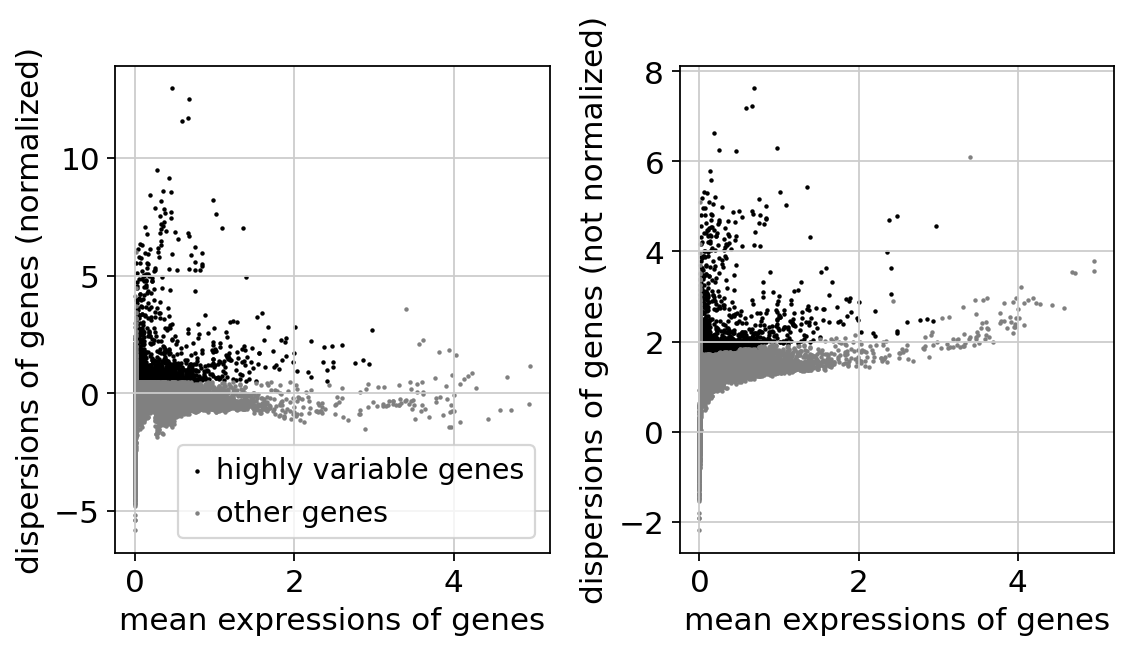

CPU times: user 592 ms, sys: 0 ns, total: 592 ms
Wall time: 589 ms


In [37]:
%%time
sc.pl.highly_variable_genes(adata)

In [38]:
adata_hvg = adata[:, adata.var['highly_variable']]

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [39]:
adata_hvg

View of AnnData object with n_obs × n_vars = 17105 × 2423
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'ccgs', 'hvg'

In [40]:
%%time
sc.pp.scale(adata_hvg, max_value=10)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
CPU times: user 636 ms, sys: 280 ms, total: 916 ms
Wall time: 915 ms


________

## PCA

In [41]:
%%time
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
CPU times: user 29.1 s, sys: 40.9 s, total: 1min 9s
Wall time: 5.98 s


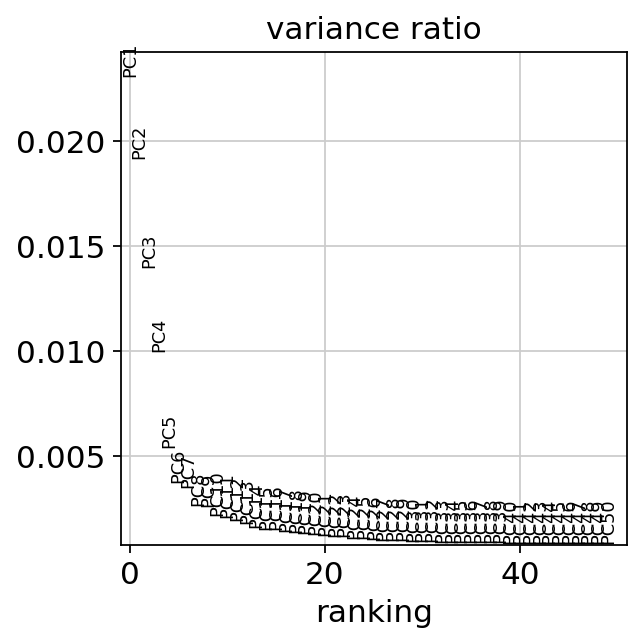

In [42]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50)

__________________________________________________________________________________________________________________________________________________________________

### Neighbourhood graph & UMAP

### BBKNN by `sample`


In [43]:
%%time
bbknn.bbknn(adata_hvg, batch_key='sample')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:04)
CPU times: user 4.03 s, sys: 0 ns, total: 4.03 s
Wall time: 4.04 s


/opt/conda/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/opt/conda/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


__________________________________________________________________________________________________________________________________________________________________

In [44]:
%%time
sc.tl.umap(adata_hvg, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
CPU times: user 19.4 s, sys: 3.21 s, total: 22.6 s
Wall time: 18 s


# Plotting

In [45]:
adata_hvg

AnnData object with n_obs × n_vars = 17105 × 2423
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'ccgs', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [46]:
markers = ['CD4','CD3G', 'FOXJ1', 'IL2R', 'TRDV2', 'CD8', # T cells
                             'CD19', 'MS4A1', # B cells
                              'CD27', 'CD38', 'JCHAIN', # Plasma B cells
                             'NCAM1', 'FCGR3A', # NK celss
                             'HBB', # Erythrocytes
                             'FCGR3B', # Neutrophils
                             'CD14', 'S100A12', # Monocytes
                             'FLT3', # Dendritic cells
                             'IRF4', 'CLEC9A', # cDC1
                             'CD1C', # cDC2
                             'TNFRSF21', # pDC and IRF4
                             'CD34', # Precursors
                             'PPBP', 'TUBB1', 'PF4', # Platelets
                             'MI67', # cycling
                            ]

### BBKNN by `sample`

50 PCs

... storing 'phase' as categorical


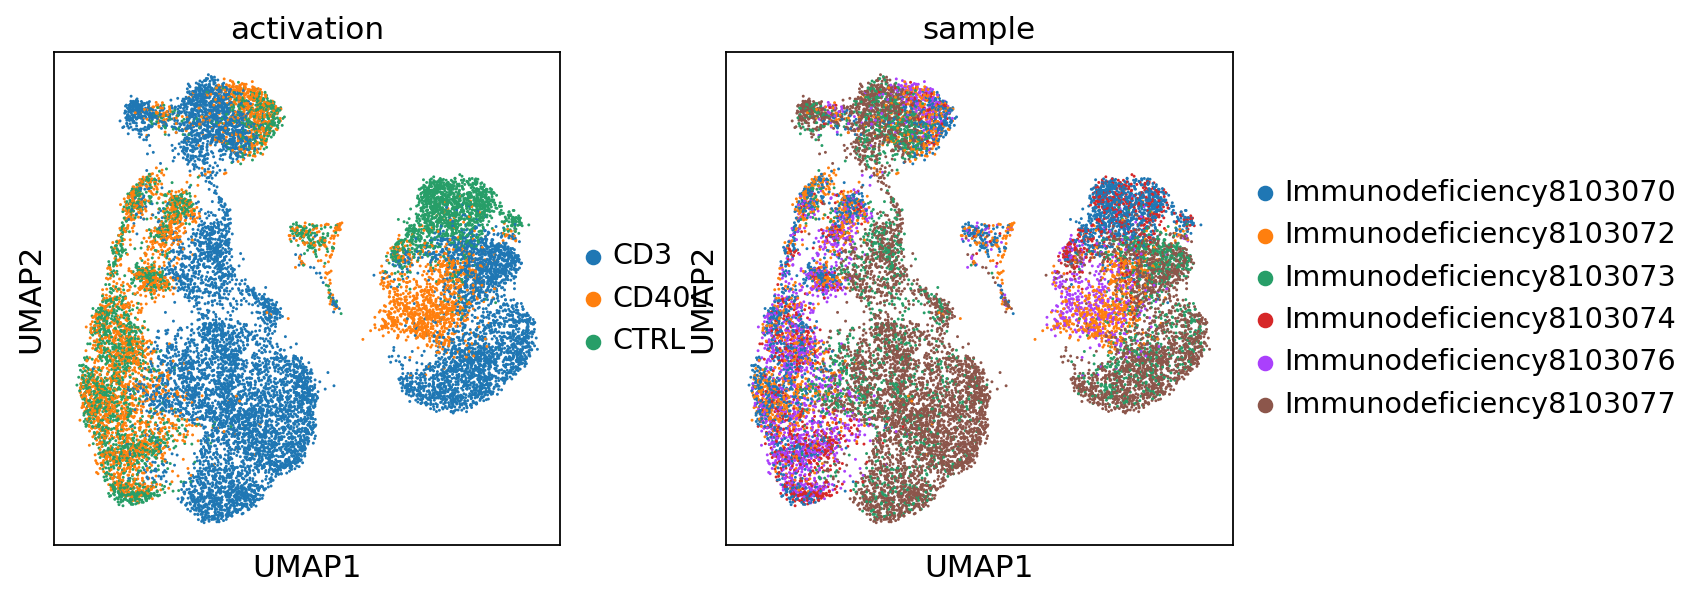

In [47]:
sc.pl.umap(adata_hvg, color=['activation','sample'])

In [74]:
adata_hvg.obs['cell_type'] = adata_final_annot.obs.loc[adata_hvg.obs_names, 'cell_type']

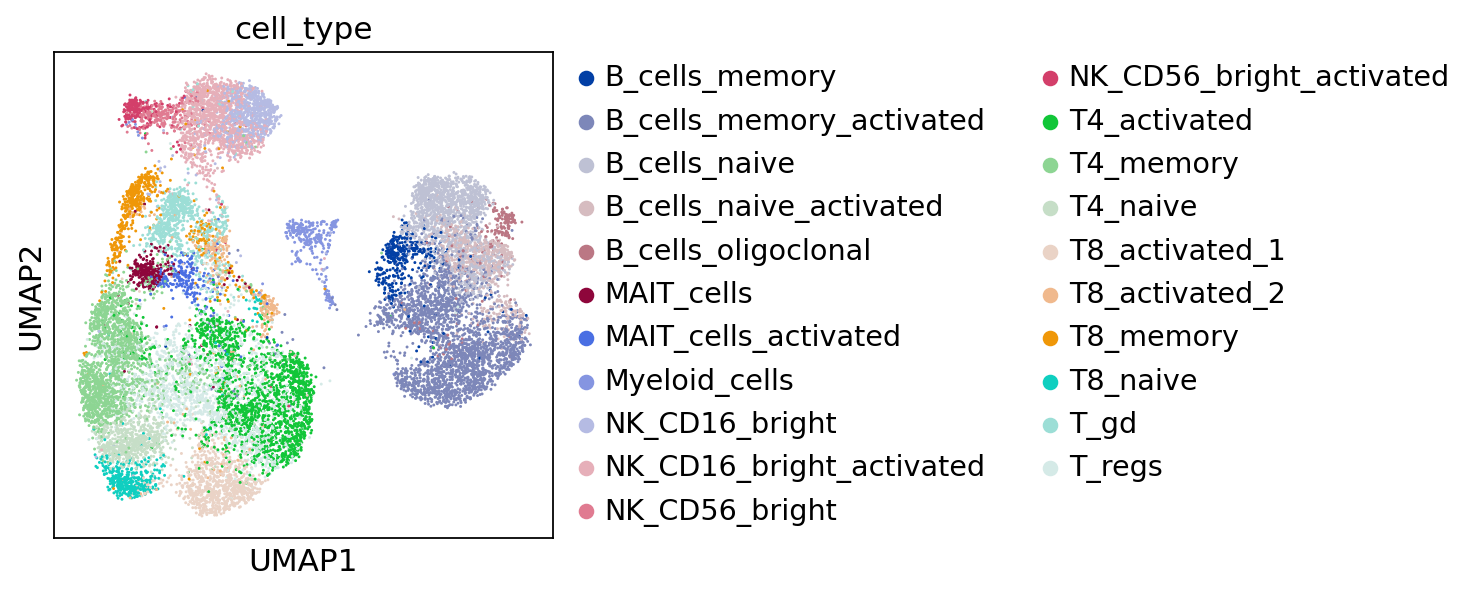

In [75]:
sc.pl.umap(adata_hvg, color=['cell_type'])

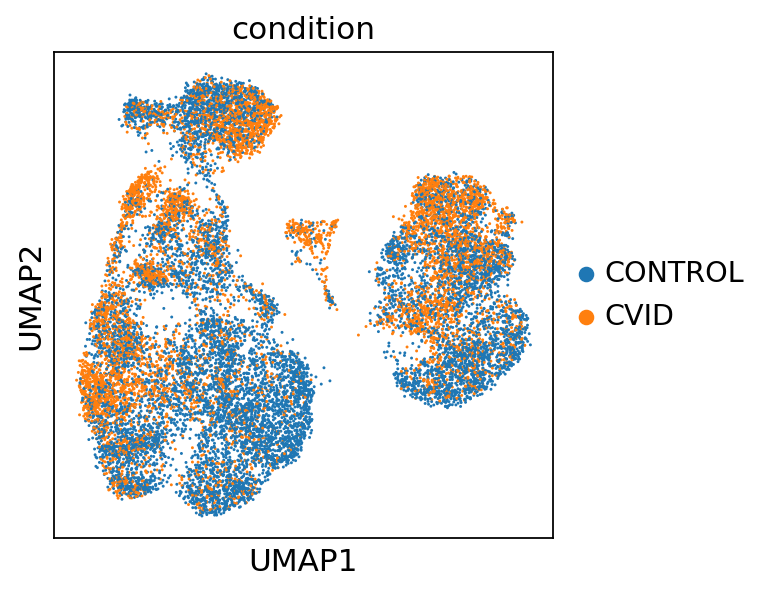

In [59]:
sc.pl.umap(adata_hvg, color=['condition'])

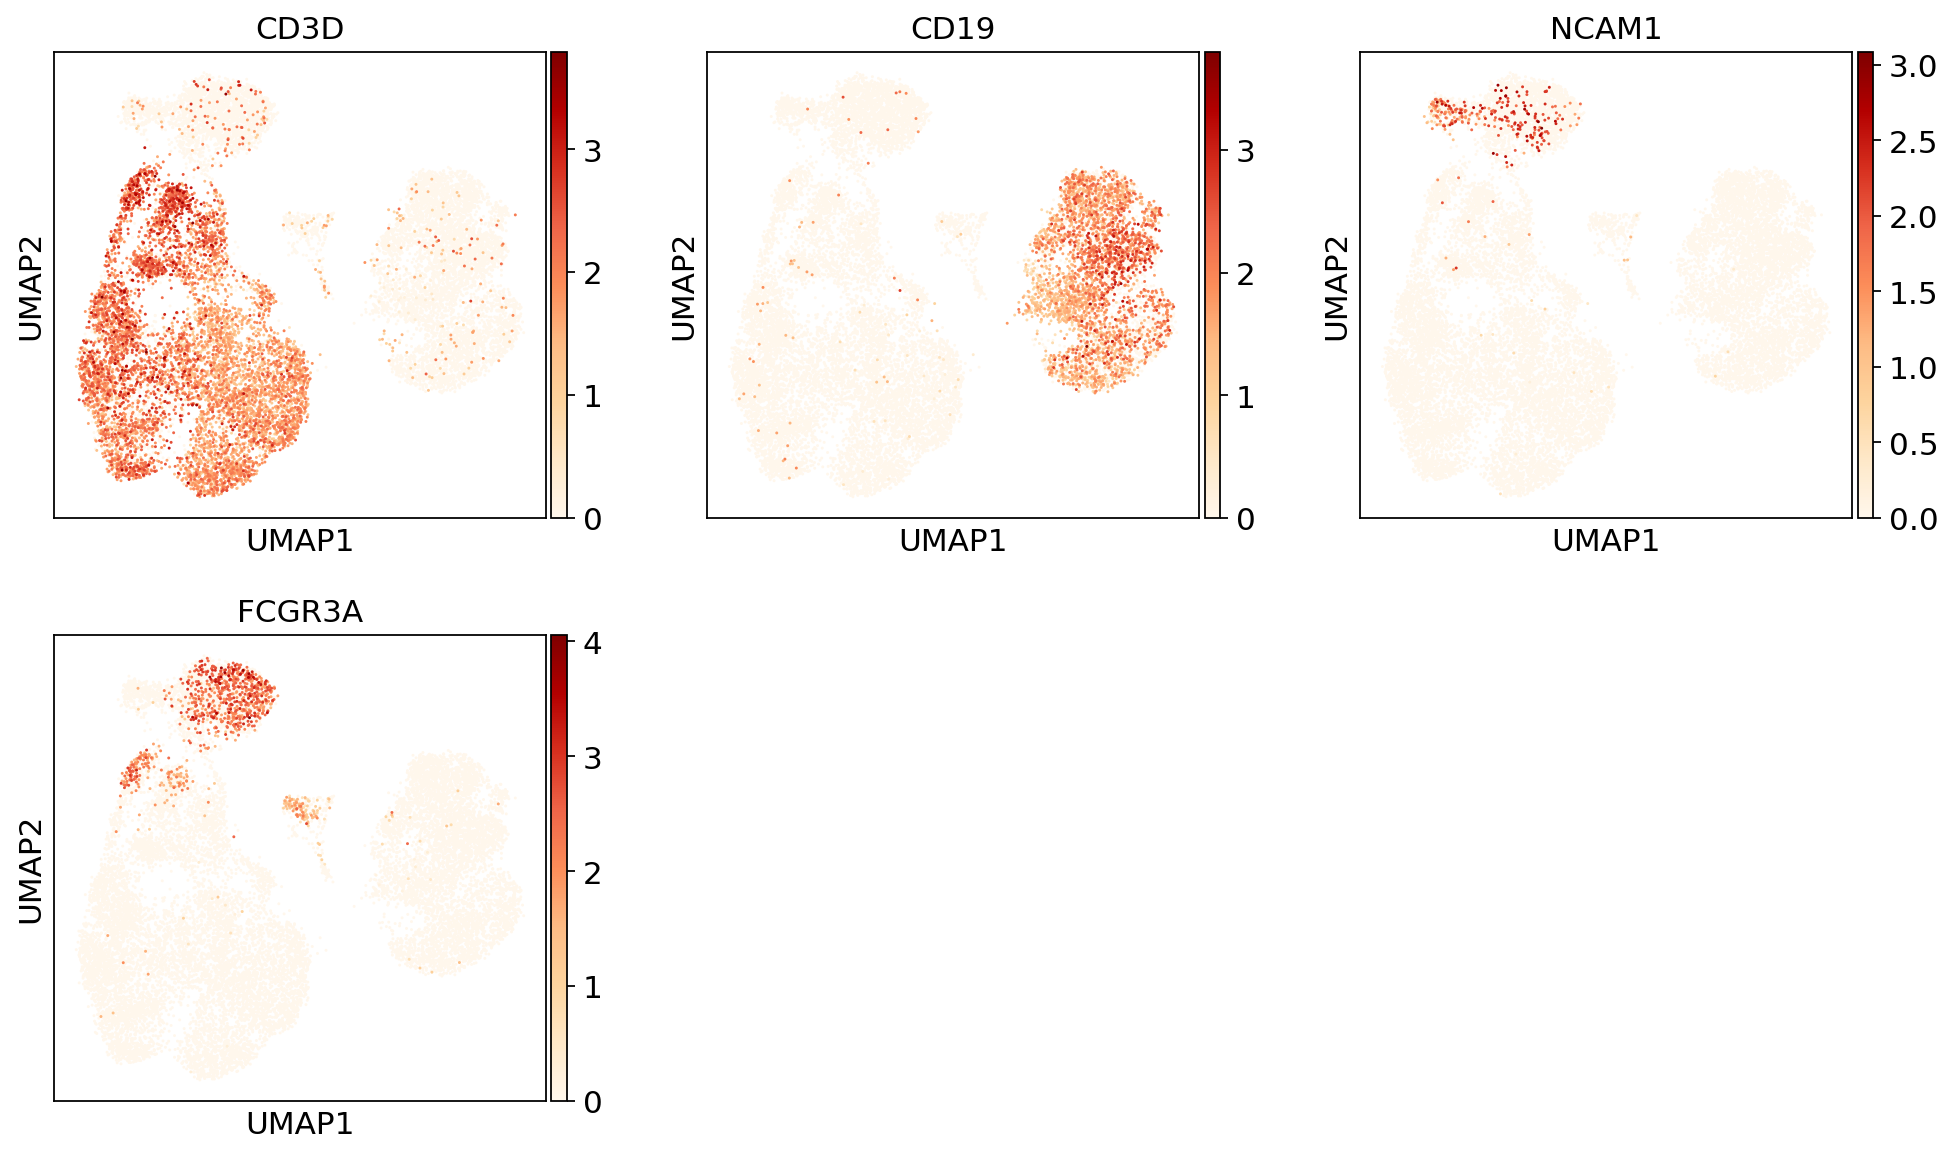

In [60]:
sc.pl.umap(adata_hvg, color=['CD3D', # T cells
                             'CD19', # B cells
                             # NK markers
                             'NCAM1', # CD56
                             'FCGR3A', # CD16
                            ], ncols=3, use_raw=True, cmap='OrRd')

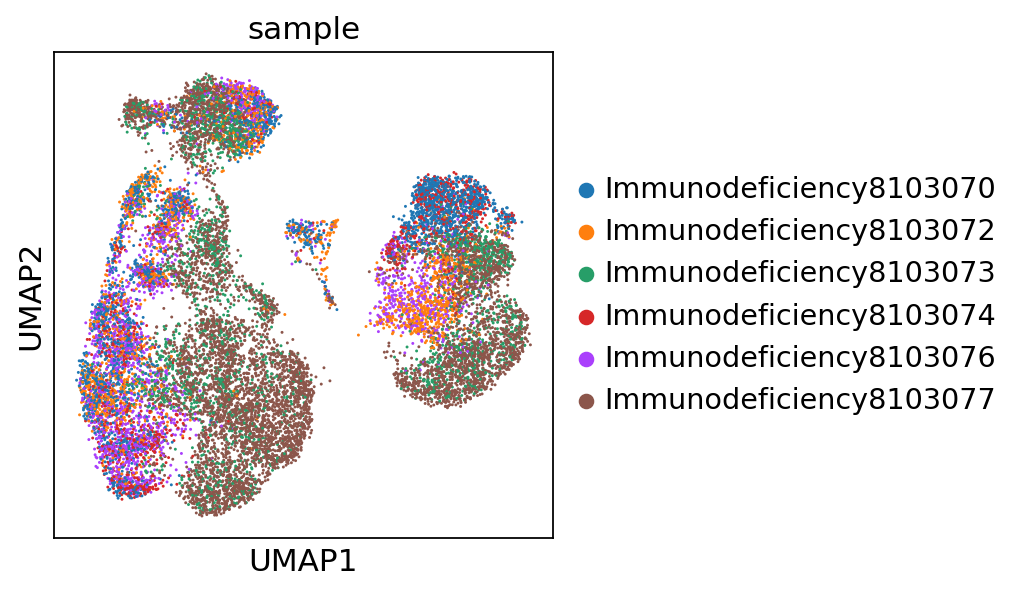

In [61]:
sc.pl.umap(adata_hvg, color=['sample'])

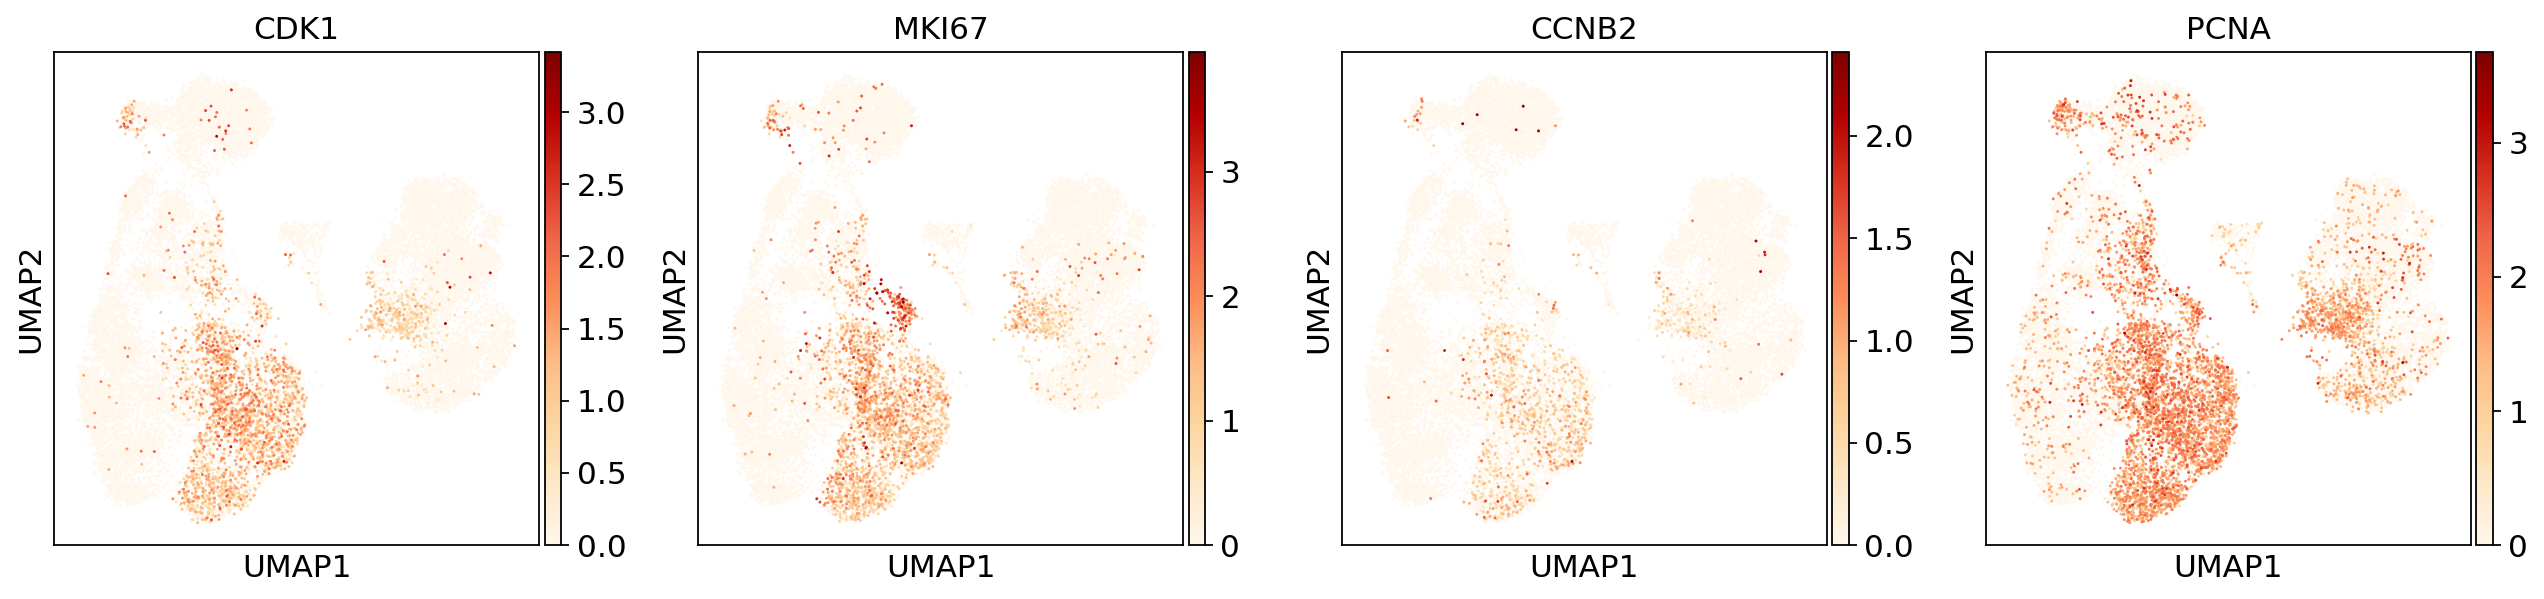

In [62]:
sc.pl.umap(adata_hvg, color=['CDK1','MKI67','CCNB2','PCNA'], cmap='OrRd')

In [63]:
adata_hvg

AnnData object with n_obs × n_vars = 17105 × 2423
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'ccgs', 'hvg', 'pca', 'neighbors', 'umap', 'activation_colors', 'sample_colors', 'cell_type_colors', 'condition_colors', 'phase_colors', 'celltype_predictions_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obs

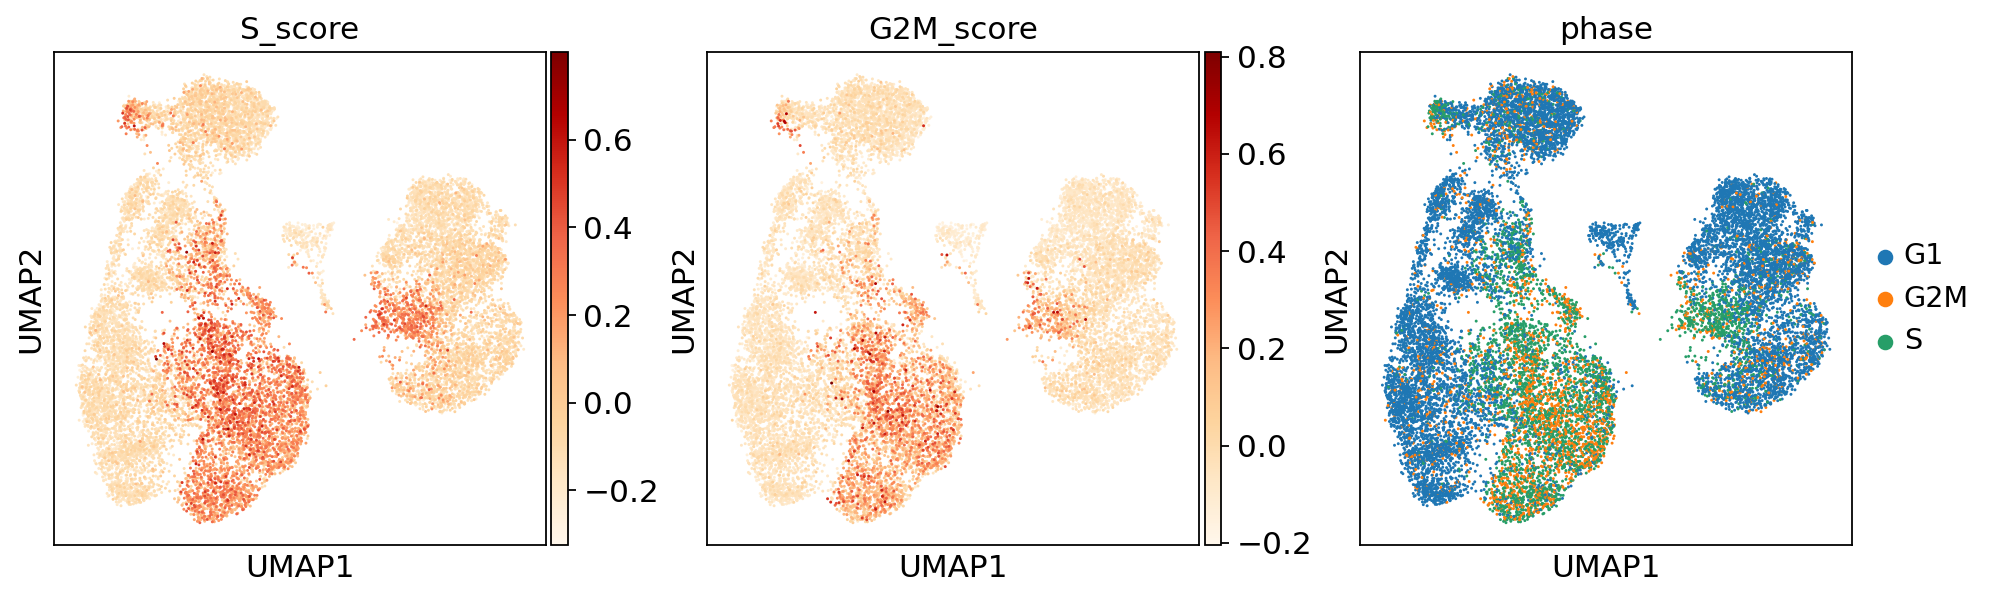

In [64]:
sc.pl.umap(adata_hvg, color=['S_score','G2M_score','phase'], cmap='OrRd')

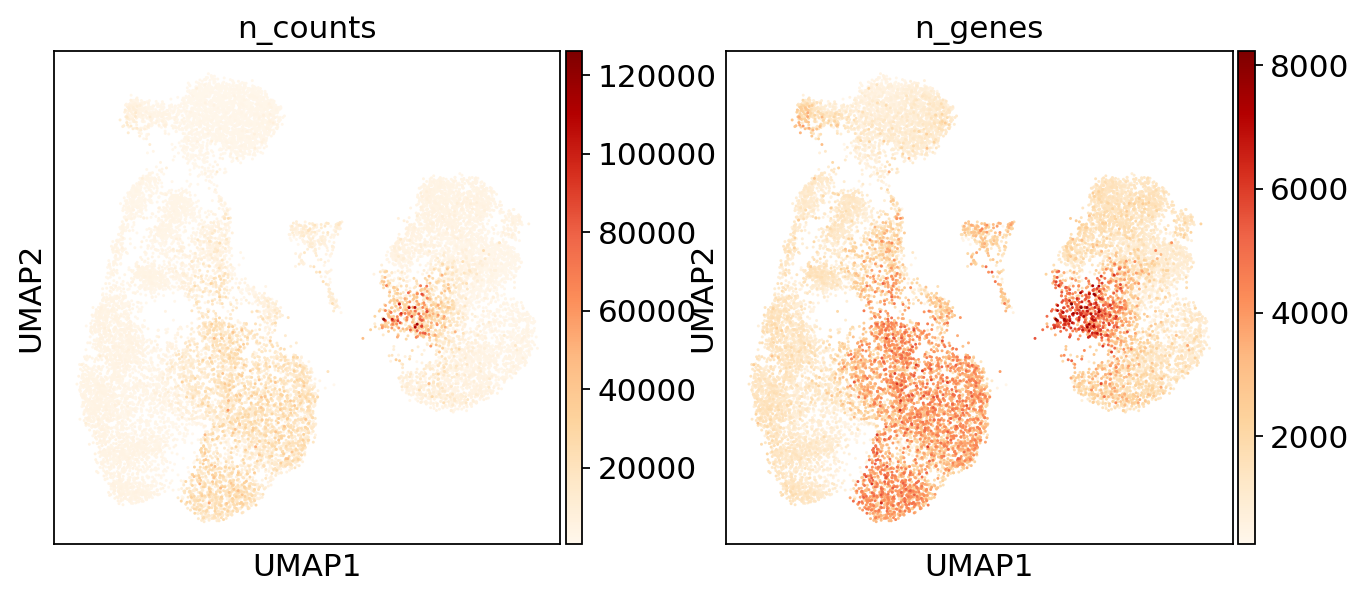

In [65]:
sc.pl.umap(adata_hvg, color=['n_counts',
                             'n_genes'], cmap='OrRd')

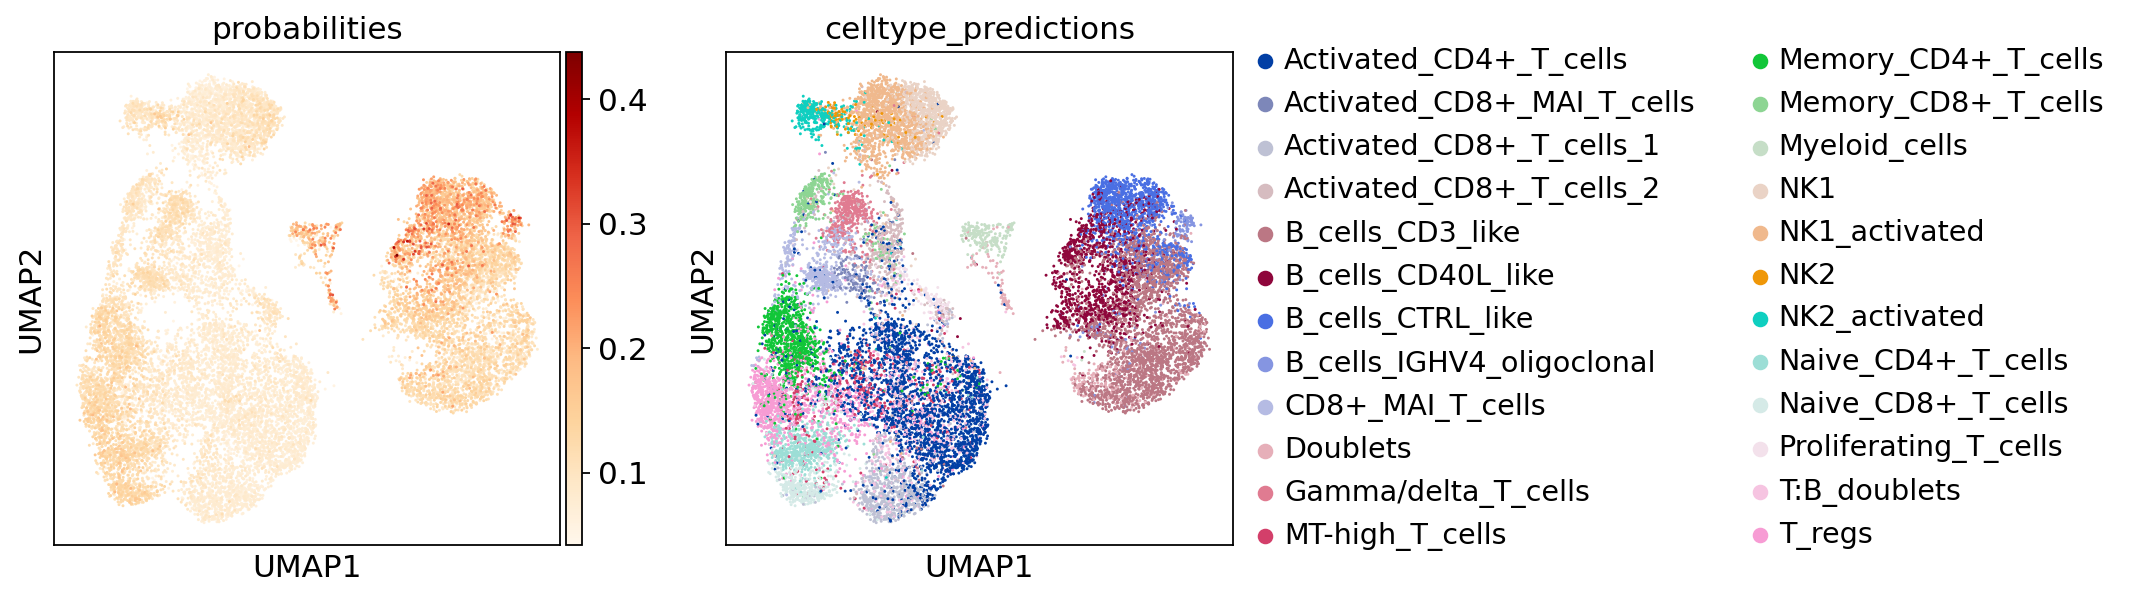

In [66]:
sc.pl.umap(adata_hvg, color=['probabilities','celltype_predictions'], cmap='OrRd')

# Saving the final version of this data

In [76]:
# resaving later
#adata_hvg.write(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_final_manifold_with_annotation.h5ad')

In [6]:
adata_hvg = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_final_manifold_with_annotation.h5ad')

In [10]:
adata_hvg

AnnData object with n_obs × n_vars = 17105 × 2423
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'activation_colors', 'ccgs', 'cell_type_colors', 'celltype_predictions_colors', 'condition_colors', 'hvg', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'conne

In [8]:
# adding corrected annotation as of 08.03.2021
annot_corrected = pd.read_csv(save_path + 'general_annotation_20210308.csv', index_col=0)

In [9]:
annot_corrected

cell_type
index                                       
TCAGGATCAGTTTACG-1  B_cells_memory_activated
GATCGCGTCCTACAGA-1             B_cells_naive
CTTGGCTCATTATCTC-1                    T_regs
TGTATTCGTACGCTGC-1            T8_activated_1
GTGTTAGGTCCGCTGA-1                      T_gd
...                                      ...
TTAGGACGTTCGTCTC-1  B_cells_memory_activated
GCGCAGTAGCCTCGTG-1            B_cells_memory
AAGACCTCAAGTAGTA-1   B_cells_naive_activated
TATTACCTCACCCGAG-1              T4_activated
CCTTCCCCAACTGCTA-1                 T4_memory

[17315 rows x 1 columns]

In [11]:
annot_corrected['cell_type'].value_counts()

T4_activated                2927
B_cells_memory_activated    2472
T4_memory                   1772
B_cells_naive               1568
NK_CD16_bright_activated    1235
T8_activated_1               830
NK_CD16_bright               763
T_gd                         697
B_cells_naive_activated      696
T4_naive                     675
T8_memory                    558
T8_naive                     408
B_cells_memory               391
T_regs                       388
MAIT_cells                   299
T8_activated_2               288
Myeloid_cells                285
NK_CD56_bright               238
MAIT_cells_activated         219
B:T_doublets_by_BCR          210
NK_CD56_bright_activated     200
B_cells_oligoclonal          196
Name: cell_type, dtype: int64

In [14]:
annot_corrected = annot_corrected[annot_corrected['cell_type'] != 'B:T_doublets_by_BCR']

In [15]:
annot_corrected['cell_type'].value_counts()

T4_activated                2927
B_cells_memory_activated    2472
T4_memory                   1772
B_cells_naive               1568
NK_CD16_bright_activated    1235
T8_activated_1               830
NK_CD16_bright               763
T_gd                         697
B_cells_naive_activated      696
T4_naive                     675
T8_memory                    558
T8_naive                     408
B_cells_memory               391
T_regs                       388
MAIT_cells                   299
T8_activated_2               288
Myeloid_cells                285
NK_CD56_bright               238
MAIT_cells_activated         219
NK_CD56_bright_activated     200
B_cells_oligoclonal          196
Name: cell_type, dtype: int64

In [16]:
annot_corrected

cell_type
index                                       
TCAGGATCAGTTTACG-1  B_cells_memory_activated
GATCGCGTCCTACAGA-1             B_cells_naive
CTTGGCTCATTATCTC-1                    T_regs
TGTATTCGTACGCTGC-1            T8_activated_1
GTGTTAGGTCCGCTGA-1                      T_gd
...                                      ...
TTAGGACGTTCGTCTC-1  B_cells_memory_activated
GCGCAGTAGCCTCGTG-1            B_cells_memory
AAGACCTCAAGTAGTA-1   B_cells_naive_activated
TATTACCTCACCCGAG-1              T4_activated
CCTTCCCCAACTGCTA-1                 T4_memory

[17105 rows x 1 columns]

In [17]:
adata_hvg

AnnData object with n_obs × n_vars = 17105 × 2423
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'activation_colors', 'ccgs', 'cell_type_colors', 'celltype_predictions_colors', 'condition_colors', 'hvg', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'conne

In [13]:
adata_hvg.obs['cell_type'].value_counts()

B_cells_memory_activated    2472
T4_memory                   1772
T4_activated                1739
T_regs                      1576
B_cells_naive               1568
NK_CD16_bright_activated    1235
T8_activated_1               830
NK_CD16_bright               763
T_gd                         697
B_cells_naive_activated      696
T4_naive                     675
T8_memory                    558
T8_naive                     408
B_cells_memory               391
MAIT_cells                   299
T8_activated_2               288
Myeloid_cells                285
NK_CD56_bright               238
MAIT_cells_activated         219
NK_CD56_bright_activated     200
B_cells_oligoclonal          196
Name: cell_type, dtype: int64

In [18]:
adata_hvg.obs['cell_type_corrected'] = annot_corrected.loc[adata_hvg.obs_names, 'cell_type']

... storing 'cell_type_corrected' as categorical


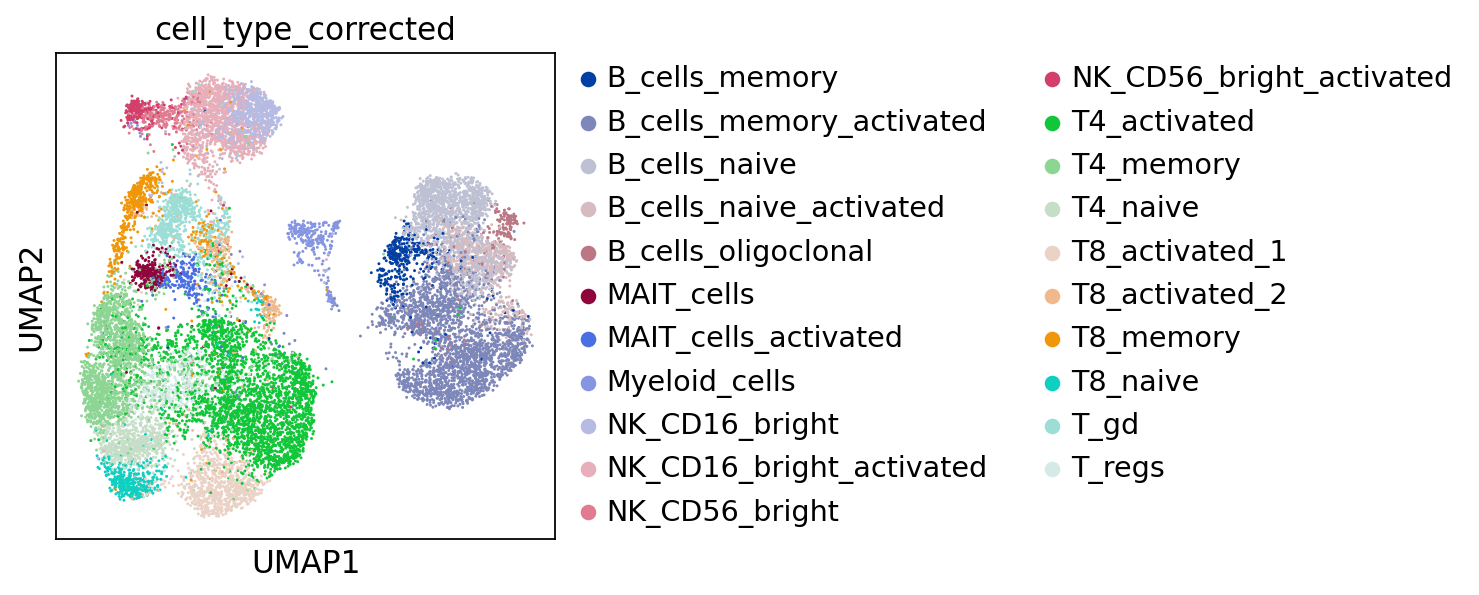

In [19]:
sc.pl.umap(adata_hvg, color='cell_type_corrected')

In [20]:
adata_hvg.write(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_final_manifold_with_annotation.h5ad')

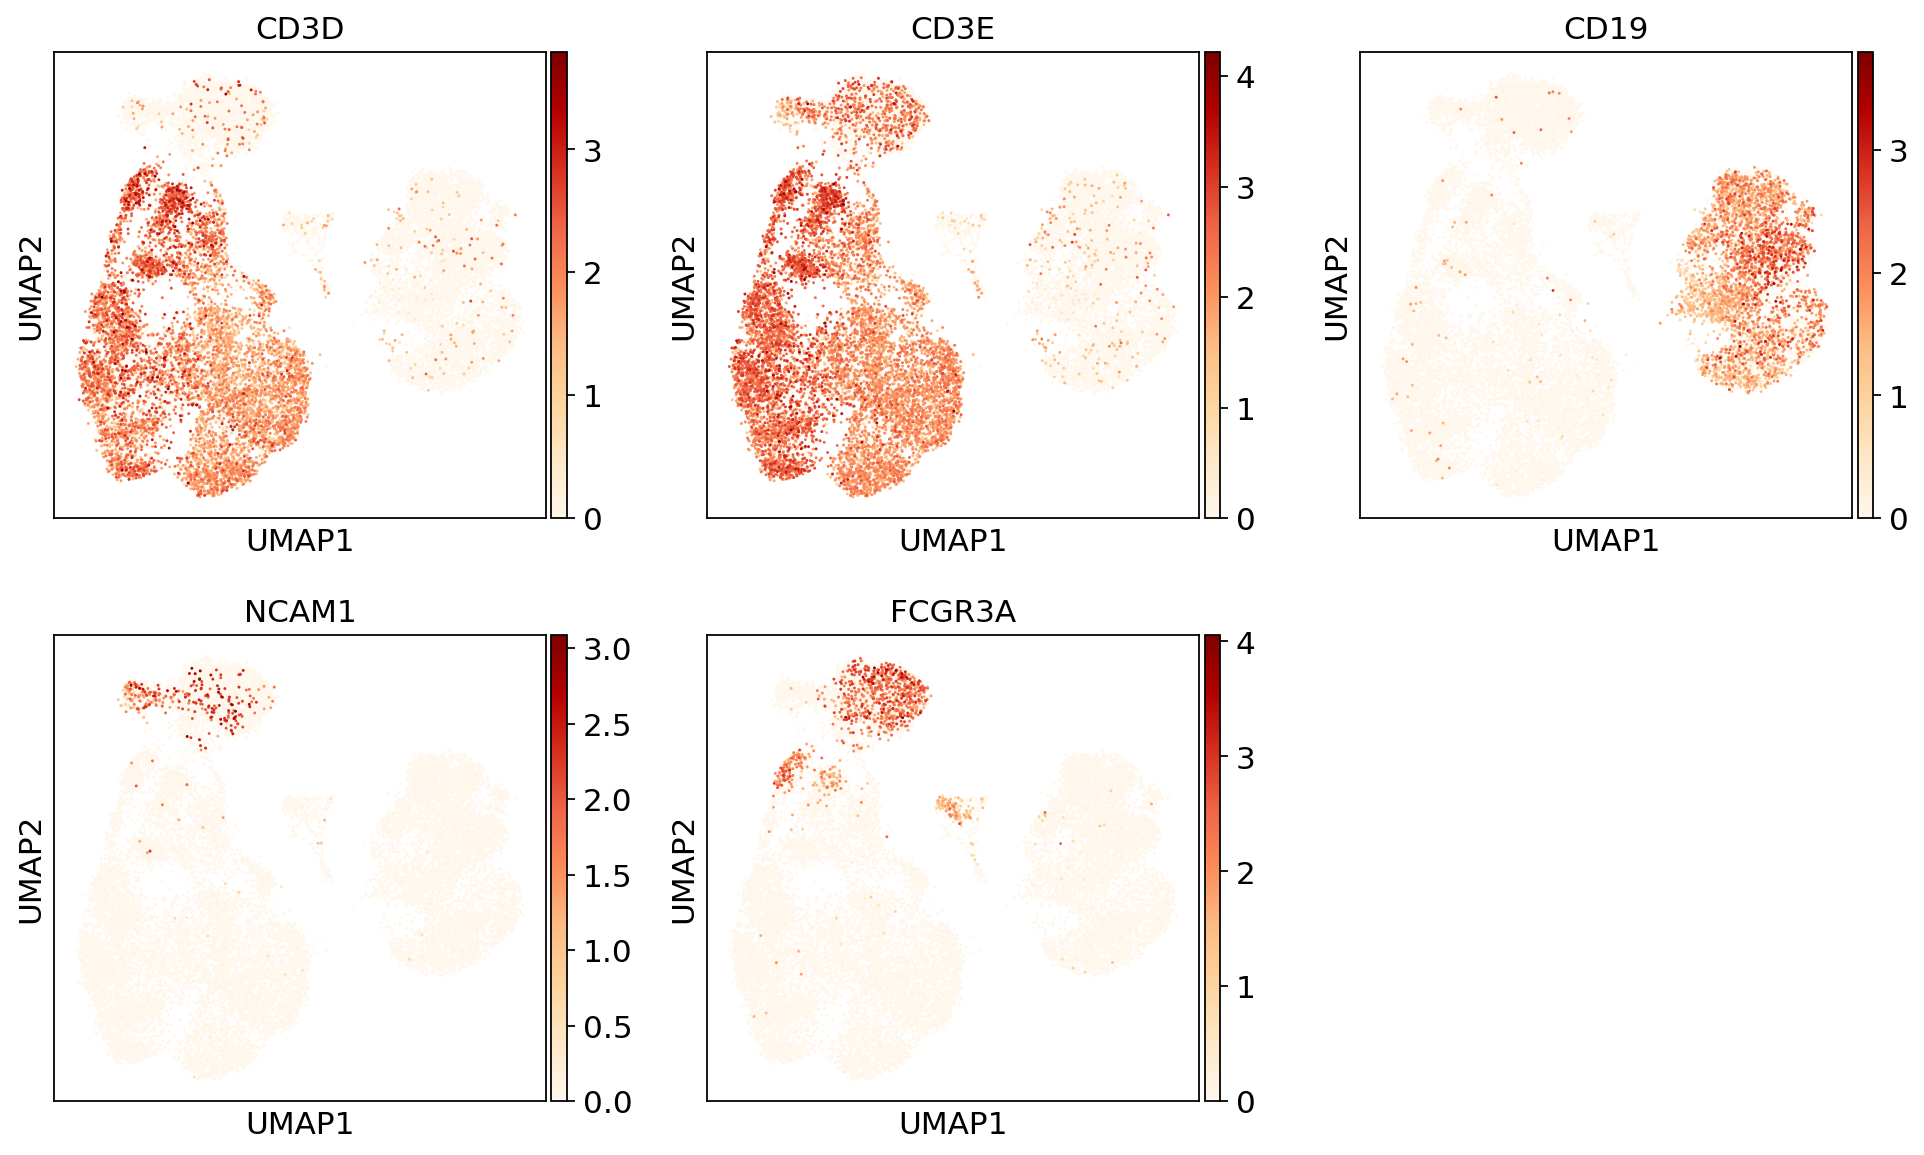

In [9]:
sc.pl.umap(adata_hvg, color=['CD3D', # T cells
                             'CD3E',
                             'CD19', # B cells
                             # NK markers
                             'NCAM1', # CD56
                             'FCGR3A', # CD16
                            ], ncols=3, use_raw=True, cmap='OrRd')